In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt 

from scipy.ndimage import gaussian_filter
from scipy.stats.mstats import pearsonr

from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pandas as pd
import polychrom
from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file
import matplotlib.pyplot as plt
from scipy import ndimage
import matplotlib.ticker as ticker
import dynamic_extrusion_boundaries.util_visual as utvis
import warnings
import h5py 
import ast

In [2]:
path_dict = {}

directory = '/scratch1/rahmanin/dynamical_boundary_simulations/simulation_md/simulation_with_pause_mod/simulations_with_hsteps/'

for name  in glob.glob(directory+'sims_o/folder_*'):
    path_dict[name.split('/sims_o/')[1][:]]= name
path_dict = dict(sorted(path_dict.items()))

In [3]:
resolution_nm =50. # resolution of image to render (in nm)
length_unit_nm = 50. # model unit of length (in nm)
gaussian_width_nm = 145. # radius of the (pseudo-Airy) diffraction disk

fraction_bound = 1. # fraction of chromatin-bound cohesin

### functions 

In [4]:
# 3d rasterizer function
resolution_nm =50. # resolution of image to render (in nm)
length_unit_nm = 50. # model unit of length (in nm)
gaussian_width_nm = 151. # radius of the (pseudo-Airy) diffraction disk

fraction_bound = 1. # fraction of chromatin-bound cohesin
def rasterize(positions, bins, gaussian_width_nm):
    n_voxels = len(bins) - 1
    
    digitized_x = np.digitize(positions[:,0], bins) - 1
    digitized_y = np.digitize(positions[:,1], bins) - 1
    digitized_z = np.digitize(positions[:,2], bins) - 1 
                    
    digitized = digitized_x + digitized_y*n_voxels + digitized_z*n_voxels**2
    bincounts = np.bincount(digitized, minlength=n_voxels**3)
                    
    raster = bincounts.reshape((n_voxels,n_voxels,n_voxels))
    smoothed_raster = gaussian_filter(raster/raster.max(), sigma=gaussian_width_nm/resolution_nm) 

    return raster, smoothed_raster

dna_colors = [(0, 0, 0), (0, 0, 1)] # first color is black, last is blue
cohesin_colors = [(0, 0, 0), (1, 0, 1)] # first color is black, last is magenta

cm_dna = LinearSegmentedColormap.from_list("Custom", dna_colors, N=15)
cm_cohesin = LinearSegmentedColormap.from_list("Custom", cohesin_colors, N=15)

### analysis

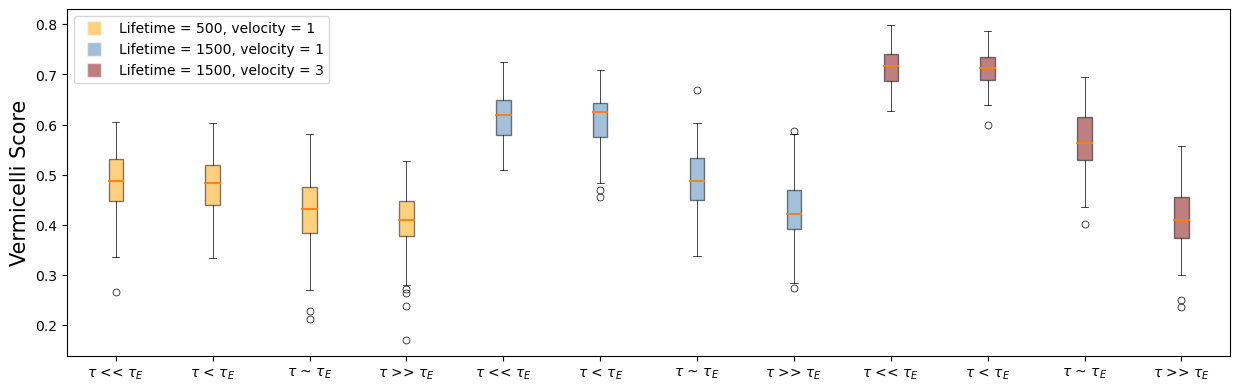

In [5]:
# Define dataset parameters
folder_parameters = [
    {"Clife": 10.0, "Cof": 1.0, "life": 500.0, "slife": 500.0, "vel": 1},
    {"Clife": 150.0, "Cof": 15.0, "life": 500.0, "slife": 500.0, "vel": 1},
    {"Clife": 1500.0, "Cof": 150.0, "life": 500.0, "slife": 500.0, "vel": 1},
    {"Clife": 15000.0, "Cof": 1500.0, "life": 500.0, "slife": 500.0, "vel": 1},
    {"Clife": 10.0, "Cof": 1.0, "life": 1500.0, "slife": 1500.0, "vel": 1},
    {"Clife": 150.0, "Cof": 15.0, "life": 1500.0, "slife": 1500.0, "vel": 1},
    {"Clife": 1500.0, "Cof": 150.0, "life": 1500.0, "slife": 1500.0, "vel": 1},
    {"Clife": 15000.0, "Cof": 1500.0, "life": 1500.0, "slife": 1500.0, "vel": 1},
    {"Clife": 10.0, "Cof": 1.0, "life": 1500.0, "slife": 1500.0, "vel": 3},
    {"Clife": 150.0, "Cof": 15.0, "life": 1500.0, "slife": 1500.0, "vel": 3},
    {"Clife": 1500.0, "Cof": 150.0, "life": 1500.0, "slife": 1500.0, "vel": 3},
    {"Clife": 15000.0, "Cof": 1500.0, "life": 1500.0, "slife": 1500.0, "vel": 3},
]

# Function to generate labels based on Clife value
def get_label(clife):
    if clife == 10.0:
        return r'$\tau$ << $\tau_E$'
    elif clife == 150.0:
        return r'$\tau$ < $\tau_E$'
    elif clife == 1500.0:
        return r'$\tau$ ~ $\tau_E$'
    elif clife == 15000.0:
        return r'$\tau$ >> $\tau_E$'

# Function to determine color based on life and velocity
def get_color(life, vel):
    if life == 500.0 and vel == 1:
        return 'orange'
    elif life == 1500.0 and vel == 1:
        return 'steelblue'
    elif life == 1500.0 and vel == 3:
        return 'maroon'

# Load data and generate labels/colors
all_data = []
labels = []
colors = []

for params in folder_parameters:
    clife, cof, life, vel = params["Clife"], params["Cof"], params["life"], params["vel"]
    file_path = f'../output/scores/simulation/vscore/vscore_for_clife_{clife}_cof_{cof}_life_{life}_vel_{vel}.csv'
    file_data = np.loadtxt(file_path)
    
    all_data.append(file_data)
    labels.append(get_label(clife))
    colors.append(get_color(life, vel))

# Plot data
fig, ax = plt.subplots(figsize=(15, 4.5))

box = ax.boxplot(
    all_data, labels=labels, widths=0.15, patch_artist=True,
    medianprops={"linewidth": 1.35},
    capprops={"linewidth": 0.5},
    flierprops={"markersize": 5, "linewidth": 0.05, "markeredgewidth": 0.5},
    whiskerprops={"linewidth": 0.5}
)

# Apply colors to boxes
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)

# Add legend
legend_colors = ['orange', 'steelblue', 'maroon']
legend_labels = [
    'Lifetime = 500, velocity = 1',
    'Lifetime = 1500, velocity = 1',
    'Lifetime = 1500, velocity = 3'
]
legend_patches = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, alpha=0.5) for color in legend_colors]
ax.legend(legend_patches, legend_labels, fontsize=10)

# Formatting
ax.set_ylabel('Vermicelli Score', fontsize=15)
plt.xticks(rotation=0)
plt.savefig('../output/figures/vermicelli_with_boxplot.png', bbox_inches='tight')
plt.show()


### Visualization 

folder_face_1.0_back_0_Clife_22.86_Cof_9.8_life_3500.0_slife_3500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_175.0_vel_1
1045


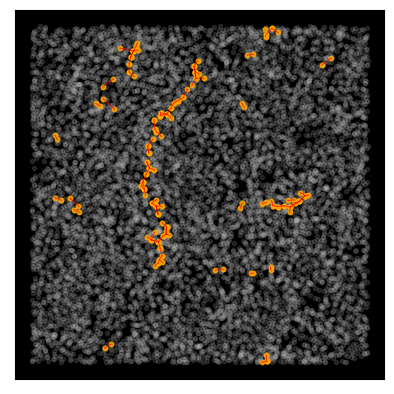

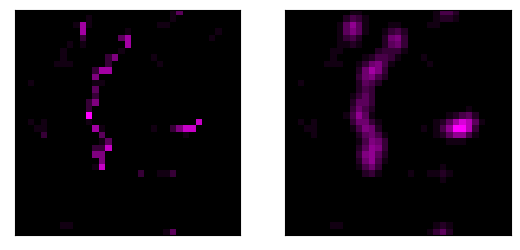

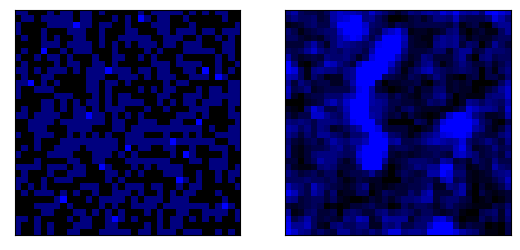

0.7168717713115021
folder_face_1.0_back_0_Clife_22.86_Cof_9.8_life_3500.0_slife_3500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_175.0_vel_1 0.7168717713115021
folder_face_1.0_back_0_Clife_2285.71_Cof_979.59_life_3500.0_slife_3500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_175.0_vel_1
1045


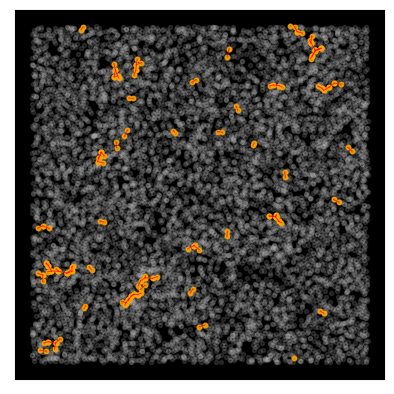

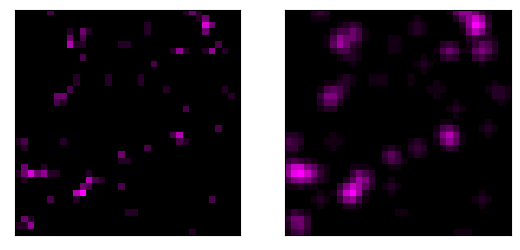

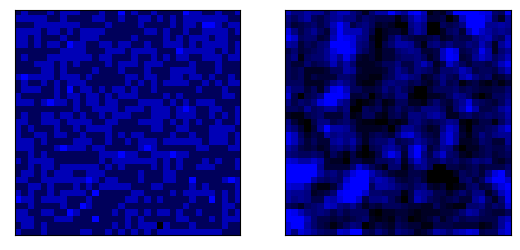

0.5950788284619797
folder_face_1.0_back_0_Clife_2285.71_Cof_979.59_life_3500.0_slife_3500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_175.0_vel_1 0.5950788284619797


In [38]:
folder_dict = [     
               'folder_face_1.0_back_0_Clife_22.86_Cof_9.8_life_3500.0_slife_3500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_175.0_vel_1',
               #'folder_face_1.0_back_0_Clife_228.57_Cof_97.96_life_3500.0_slife_3500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_175.0_vel_1',
               'folder_face_1.0_back_0_Clife_2285.71_Cof_979.59_life_3500.0_slife_3500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_175.0_vel_1',
               ]
path = '/scratch1/rahmanin/dynamical_boundary_simulations/simulation_md/simulation_with_pause_mod/simulations_with_hsteps/sims_o/'
sns.reset_defaults()      
#ver_score = []
for name in list(folder_dict)[:]:
    v_score = []
    print(name)
    params = [ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
    face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
    for frame in range(1045,1985,7500):
        URIs= polychrom.hdf5_format.list_URIs(path+name)
        xyz=polychrom.hdf5_format.load_URI(URIs[frame])['pos']
        

    
        # determining a box 
        box_size = (10000/0.2)**0.33
        #box_size = 50
        box = [box_size, box_size, box_size]
        xyz = np.mod(xyz, box)
        #plt.scatter(xyz[:,0],xyz[:,1], xyz[:,2],alpha=0.5,color='tan') 
        #plt.show()
        
        # center them around the box
        xyz = xyz-box_size/2
        x=xyz[:,0]
        y=xyz[:,1]
        z=xyz[:,2]
        #plt.scatter(x,y,alpha=0.5,color='tan') 
        #plt.show()
        
        # indeces of extruder monomers
        lefs = h5py.File(path+name+'/LEFPositions.h5','r')["positions"]
        lefs = np.array(lefs)//10
    
        # bins inside the box
        n_voxels = int(box_size / (resolution_nm/length_unit_nm)) #number of boxes inside the main box
        bins = np.linspace(-box_size/2., box_size/2., num=n_voxels+1)
    
        # postitions of cohesins
        cohesin_bonds = lefs[(frame+1)*100 ]
        monomer_positions = xyz.copy()
        cohesin_positions = monomer_positions[cohesin_bonds].copy().reshape((-1,3))
        #print(cohesin_positions)
        print(frame)
        for i in range(0,len(cohesin_positions)-3,2):
            pair_pos_x = [cohesin_positions[i][0],cohesin_positions[i+1][0]]
            pair_pos_y = [cohesin_positions[i][1],cohesin_positions[i+1][1]]
            if np.abs(np.diff(pair_pos_x)[0])<5 and np.abs(np.diff(pair_pos_y)[0])<5:
                #print(np.abs(np.diff(pair_pos_x)[0]))
                #print(pair_pos_x)
                plt.plot(pair_pos_x,pair_pos_y,color='red',linewidth=0.75, alpha=0.7)
            
        x_c, y_c, z_c = cohesin_positions[:,0], cohesin_positions[:,1], cohesin_positions[:,2]
        plt.scatter(monomer_positions[:,0],monomer_positions[:,1],s=8.5,color ='silver',alpha=0.15)#,monomer_positions[:,2])
        plt.scatter(x_c, y_c,marker='o',color='orange' ,s=10.5, alpha=0.8)# z_c)
        plt.gca().set_facecolor('black')
        plt.gca().set_aspect('equal')
        #plt.title(r'lifetime = %s, vel = %s, $\tau$ = %s, $\tau\prime$ = %s'%(life,vel,clife,cof))
        plt.gca().xaxis.set_visible(False)
        plt.gca().yaxis.set_visible(False) 
        plt.gca().invert_yaxis()
        #plt.savefig(r'vfigs/frame_%s_scatter_plot_lifetime_%s_vel_%s_$\tau$_%s_$\tau\prime$_%s.pdf'%(frame,life,vel,clife,cof))
        plt.show()

        
        raster_dna, gaussian_raster_dna = rasterize(monomer_positions, bins, gaussian_width_nm=51)
        raster_cohesin, gaussian_raster_cohesin = rasterize(cohesin_positions, bins, gaussian_width_nm=51)
    
        
        plt.subplot(1,2,1)
        plt.imshow(raster_cohesin.max(axis=0), cmap=cm_cohesin) # Plot maximum intensity projection along z axis
        plt.gca().xaxis.set_visible(False)
        plt.gca().yaxis.set_visible(False)
        
        
        plt.subplot(1,2,2)
        plt.imshow(gaussian_raster_cohesin.max(axis=0), cmap=cm_cohesin)
        plt.gca().xaxis.set_visible(False)
        plt.gca().yaxis.set_visible(False)   
        #plt.savefig(r'vfigs/frame_%s_cohesin_plot_lifetime_%s_vel_%s_$\tau$_%s_$\tau\prime$_%s.pdf'%(frame,life,vel,clife,cof))
        plt.show()
        plt.subplot(1,2,1)
    
        plt.imshow(raster_dna.max(axis=0), cmap=cm_dna) # Plot maximum intensity projection along z axis
        
        plt.gca().xaxis.set_visible(False)
        plt.gca().yaxis.set_visible(False)
        #plt.show()
        
        plt.subplot(1,2,2)
        
        plt.imshow(gaussian_raster_dna.max(axis=0), cmap=cm_dna,vmin=0.0985, vmax=0.1985)
        
        plt.gca().xaxis.set_visible(False)
        plt.gca().yaxis.set_visible(False)
        #plt.savefig(r'vfigs/frame_%s_dna_plot_lifetime_%s_vel_%s_$\tau$_%s_$\tau\prime$_%s.pdf'%(frame,life,vel,clife,cof),transparent=True)
        plt.show()

        raster_dna, gaussian_raster_dna = rasterize(monomer_positions, bins, gaussian_width_nm=151)
        raster_cohesin, gaussian_raster_cohesin = rasterize(cohesin_positions, bins, gaussian_width_nm=151)
        
        # getting vermicelli score from the spatial cohesin/dna cross-correlation
        vermicelli_score = pearsonr(gaussian_raster_cohesin, gaussian_raster_dna)[0]
        v_score.append(vermicelli_score)
        print(vermicelli_score)
        #asdf
    
    #ver_score.append([clife,cof,life,vel,np.mean(v_score)])
    print(name, np.mean(v_score))
        
    
        

### Heat maps of tau vs tau_E

In [6]:
file = pd.read_csv('../output/scores/simulation/vermic.csv')
file = file.drop_duplicates()
lifetime = file['life']
velocity = file['vel']
clife = file['clife']
cof = file['cof']

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
file['occupancy'] = (file['clife']/(file['clife']+file['cof'])).round(2)

In [7]:
file=file[(file['life']<=1500000)&(file['sep']==100)]
lifetime = file['life']
velocity = file['vel']
clife = file['clife']
cof = file['cof']
sep = file['sep']
unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
file=file[['clife','cof','life','vel','sep','occupancy','vscore','std']]

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


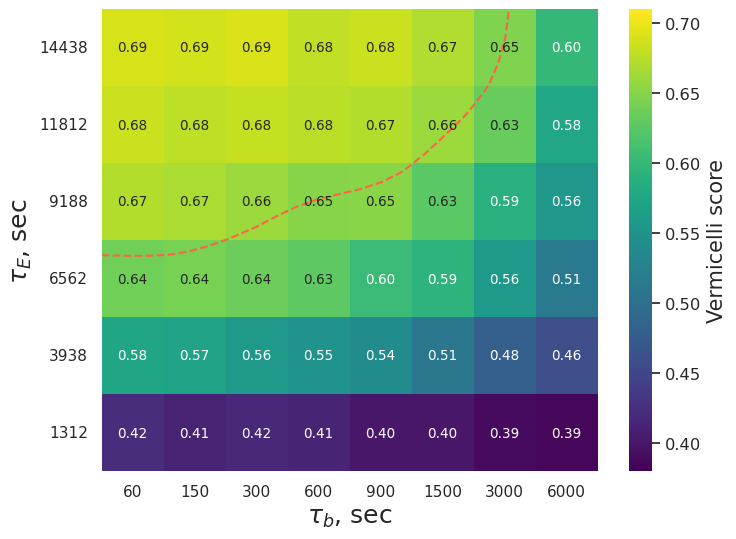

In [11]:
convertor = 21.875*60/500
for vel in list(unique_vel):
    file_70 = file[file['occupancy']==0.7]
    new_file = file_70[(velocity == vel)&(clife<=3000)&(clife>=15)][['life','clife','sep','cof','vscore']]
    new_file['life']=(new_file['life']*convertor).round()
    new_file['clife']=(new_file['clife']*convertor).round()
    heatmap_data = new_file.pivot('life', 'clife', 'vscore')
    heatmap_data = heatmap_data.astype(float)
    
    # Create the heatmap using seaborn
    plt.figure(figsize=(8, 6))
    im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', vmax=.71, vmin =0.38, fmt='.2f',cbar_kws={'label': 'Vermicelli score'} )
    sns.set(font_scale=0.81)
    cbar = im.collections[0].colorbar
    cbar.ax.tick_params(labelsize=11.75)
    cbar.set_label('Vermicelli score', fontsize=15)

    # Add equipotential lines for loop size = 700
    smooth_scale = 1
    d = gaussian_filter(heatmap_data.to_numpy(), sigma=0.1)
    #z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
    numline_o=8
    numline_c=6
    #cntr1 = im.contour(np.linspace(0, numline_o, numline_o * smooth_scale),
    #                   np.linspace(0, numline_c, numline_c * smooth_scale),
    #                   d, levels=[0.65], colors='tomato', linestyles='dotted', alpha=1)
    line = utvis.make_equipotential_lines(heatmap_data,[0.65], expand_cof = 3,
                                             num_line_x = 8, num_line_y = 6, color='tomato', linestyles='dashed')


    # Format tick labels
    im.set_xticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_xticklabels()])
    im.set_yticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_yticklabels()])
    # Customize labels and title
    plt.xticks(fontsize =11, rotation=0)
    plt.ylabel(r'$\tau_b$ [sec]', fontsize =16.5)
    plt.yticks(fontsize = 11, rotation = 0)
    plt.xlabel(r'$\tau_b$, sec', fontsize = 18)
    plt.ylabel(r'$\tau_E$, sec', fontsize =18)
    #plt.title(' velocity= %s, occupancy=0.9'%( vel), fontsize =11.5)
    plt.gca().invert_yaxis()
    plt.savefig('../output/figures/vermicelli_for_occup_0.7_vel_%s.pdf'%(vel), transparent = True, bbox_inches = 'tight')
    # Show the plot
    plt.show()